<a href="https://colab.research.google.com/github/adfhsjt/PCVK25_3F_02/blob/main/Week6_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D. PRAKTIKUM FILTER

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from google.colab.patches import cv2_imshow
from PIL import Image as im

In [51]:
def convolution2d(image, kernel, stride, padding):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    output_height = math.floor(((image_height - kernel_height + 2 * padding) / stride) + 1)
    output_width = math.floor(((image_width - kernel_width + 2 * padding) / stride) + 1)

    output = np.zeros((output_height, output_width))

    padded_image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')

    for y_out in range(output_height):
        for x_out in range(output_width):

            y_start = y_out * stride
            x_start = x_out * stride

            image_slice = padded_image[y_start : y_start + kernel_height, x_start : x_start + kernel_width]

            output[y_out, x_out] = np.sum(image_slice * kernel)

    return output

In [49]:
img= cv.imread('/content/drive/MyDrive/PCVK25_3F_02/Images/mandrill.tiff')
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)

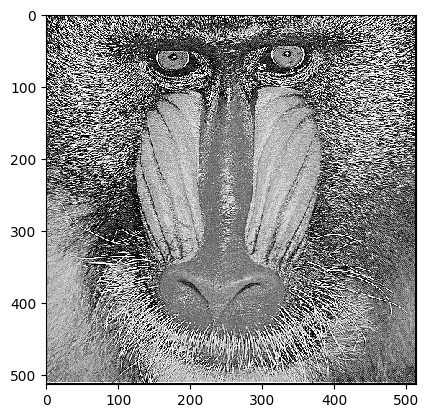

In [60]:
kernel_sharpen= np.array([[0,-1,0],
                         [-1,5,-1],
                         [0,-1,0]])

convolved_img = convolution2d(img_gray,kernel_sharpen,1,2)
plt.imshow(convolved_img, cmap='gray', vmin=0, vmax=255, interpolation='nearest')

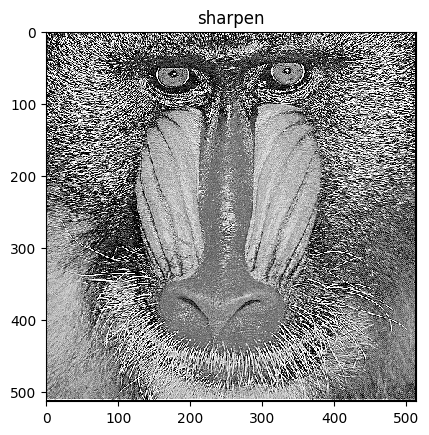

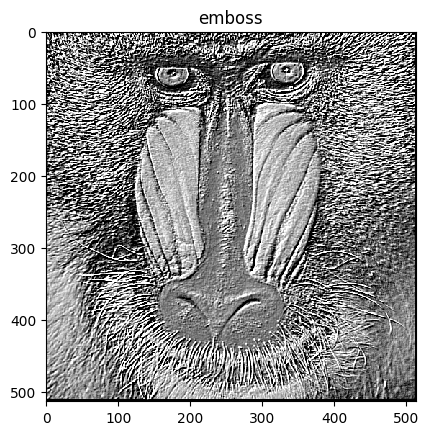

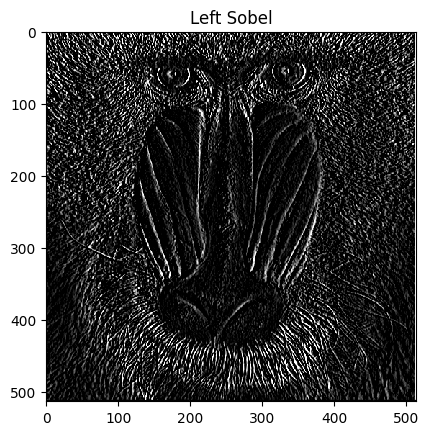

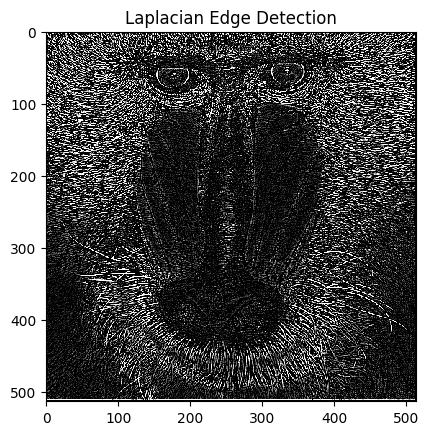

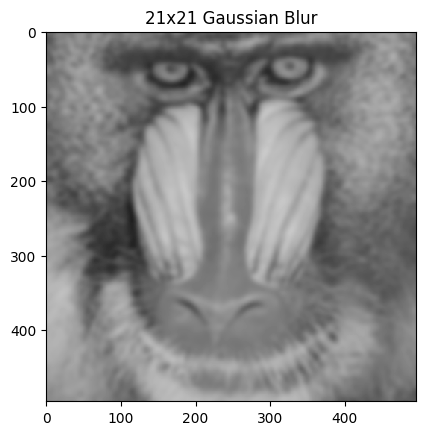

In [61]:
kernels = {}

kernels['sharpen'] = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])

kernels['emboss'] = np.array([[-2, -1, 0],
                              [-1, 1, 1],
                              [0, 1, 2]])

kernels['Left Sobel'] = np.array([[1, 0, -1],
                                  [2, 0, -2],
                                  [1, 0, -1]])

kernels['Laplacian Edge Detection'] = np.array([[-1, -1, -1],
                                                [-1, 8, -1],
                                                [-1, -1, -1]])

kernel_size = 21

sigma = 0

gaussian_kernel_1d = cv.getGaussianKernel(kernel_size, sigma)

gaussian_kernel_2d = gaussian_kernel_1d @ gaussian_kernel_1d.transpose()

kernels['21x21 Gaussian Blur'] = gaussian_kernel_2d

for kernel_name, kernel in kernels.items():
    convolved_img = convolution2d(img_gray, kernel, 1, 2)
    plt.figure()
    plt.title(kernel_name)
    plt.imshow(convolved_img, cmap='gray', vmin=0, vmax=255, interpolation='nearest')

plt.show()



# E. FILTER LIBRARY DAN FILTER MODERN

## Percobaan 1:

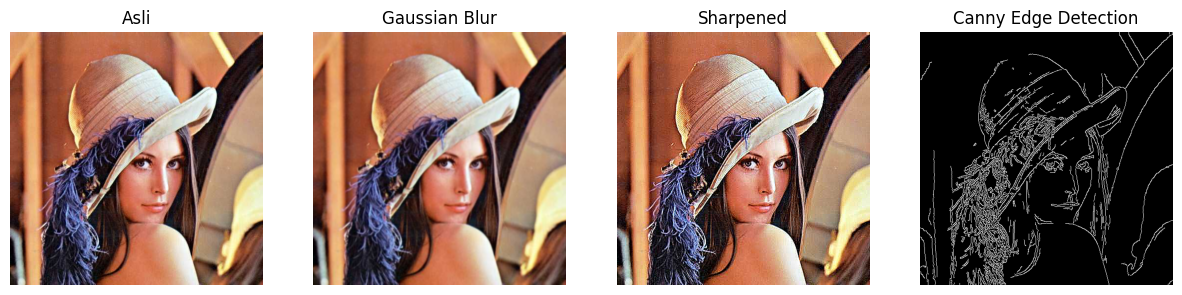

In [65]:
# Fungsi tampil berdampingan
def show_side_by_side(images, titles, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 2: # grayscale
            plt.subplot(1, len(images), i+1)
            plt.imshow(img, cmap="gray")
        else: # color
            plt.subplot(1, len(images), i+1)
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
    plt.show()

img= cv.imread('/content/drive/MyDrive/PCVK25_3F_02/Images/lena.jpg')
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)

blur = cv.GaussianBlur(img, (7,7), 1)
edges = cv.Canny(img_gray, 100, 200)

sharpen_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
sharpened = cv.filter2D(img, -1, sharpen_kernel)

show_side_by_side([img, blur, sharpened, edges],
                  ["Asli", "Gaussian Blur", "Sharpened", "Canny Edge Detection"])

## Percobaan 2

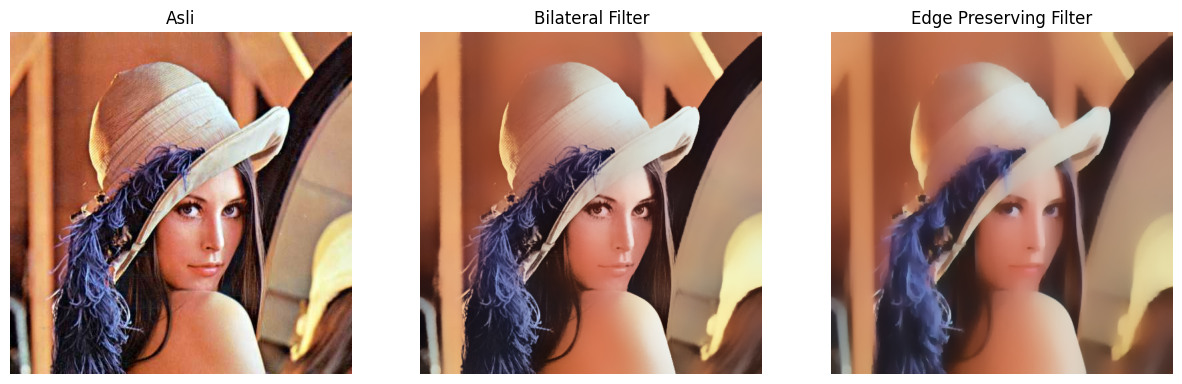

In [66]:
#Filter Modern dari OpenCV
# Bilateral Filter (edge-preserving)
bilateral= cv.bilateralFilter(img, 50,100,100)

# Edge Preserving  Filter (alternatif Guided Filter)
edge_preserve = cv.edgePreservingFilter(img, flags=1, sigma_s=100, sigma_r=0.9)

show_side_by_side([img, bilateral, edge_preserve],
                  ["Asli", "Bilateral Filter", "Edge Preserving Filter"])

## Percobaan 3

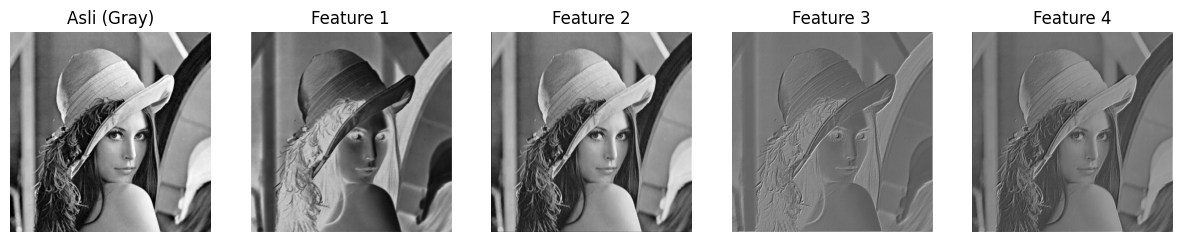

In [73]:
# Filter Feature Map yang digunakan pada CNN, Lakukan running code bagian ini beberapa kali dan perhatikan hasilnya
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv1(x)

model = SimpleCNN()

# Ubah gambar ke tensor
img_tensor = torch.tensor(img_gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0

# Hasil CNN
with torch.no_grad():
    features = model(img_tensor)

# Visualisasi feature maps
feature_maps = [features[0,i].numpy() for i in range(features.shape[1])]
show_side_by_side([img_gray] + feature_maps, ["Asli (Gray)"] + [f"Feature {i+1}" for i in range(len(feature_maps))])

## Percobaan 4

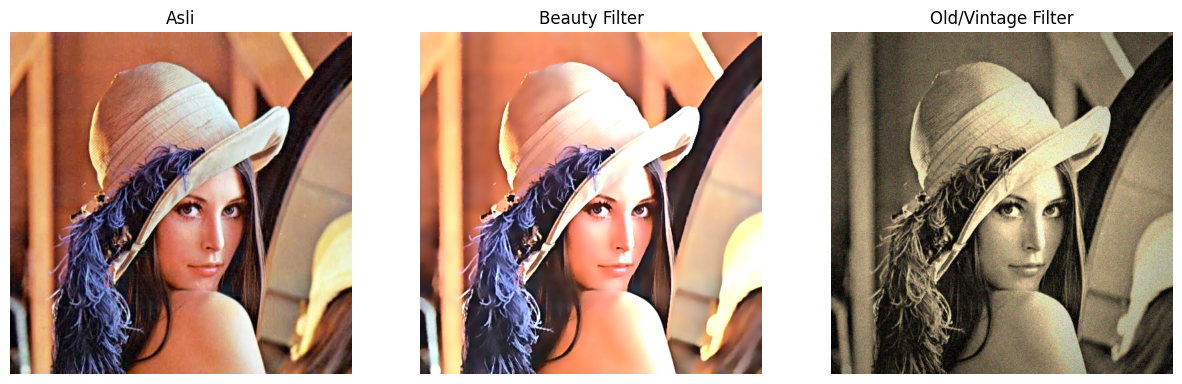

In [75]:
# ====================
# 1. Beauty Filter
# ====================

# Step 1: Smoothing kulit dengan bilateral filter
smooth = cv.bilateralFilter(img, d=15, sigmaColor=75, sigmaSpace=75)

# Step 2: Unsharp masking (pertajam mata/bibir)
gaussian = cv.GaussianBlur(smooth, (0,0), 3)
sharpened = cv.addWeighted(smooth, 1.5, gaussian, -0.5, 0)

# Step 3: Brightness & contrast
alpha = 1.2 # contrast
beta = 15 # brightness
beauty = cv.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

# ====================
# 2. Old/Vintage Filter
# ====================

# Step 1: Sepia tone
sepia_kernel = np.array([[0.272, 0.534, 0.131],
                         [0.349, 0.686, 0.168],
                         [0.393, 0.769, 0.189]])
sepia = cv.transform(img, sepia_kernel)
sepia = np.clip(sepia, 0, 255).astype(np.uint8)

# Step 2: Vignette
rows, cols = img.shape[:2]
kernel_x = cv.getGaussianKernel(cols, cols*0.6)
kernel_y = cv.getGaussianKernel(rows, rows*0.6)
kernel = kernel_y * kernel_x.T
mask = kernel / kernel.max()
vignette = np.copy(sepia)
for i in range(3):
    vignette[:,:,i] = vignette[:,:,i] * mask

# Step 3: Noise/Grain
noise = np.random.normal(0, 15, vignette.shape).astype(np.int16)
old_img = np.clip(vignette.astype(np.int16) + noise, 0, 255).astype(np.uint8)

show_side_by_side([img, beauty, old_img],
                  ["Asli", "Beauty Filter","Old/Vintage Filter"])

## Percobaan 5

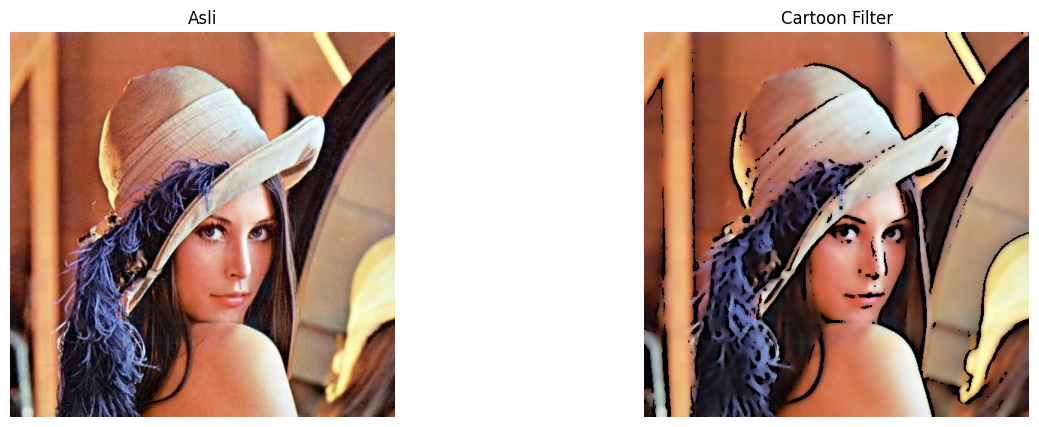

In [76]:
# Filter Anime / Cartoon
# Step 1: Edge detection (pakai median blur dulu agar gambar menjadi lebih halus)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_blur = cv.medianBlur(gray, 7)
edges = cv.adaptiveThreshold(gray_blur, 255,
                             cv.ADAPTIVE_THRESH_MEAN_C,
                             cv.THRESH_BINARY, 9, 9)

# Step 2: Bilateral filter untuk smoothing warna
color = cv.bilateralFilter(img, d=9, sigmaColor=200, sigmaSpace=200)

# Step 3: Gabungkan (cartoonize)
cartoon = cv.bitwise_and(color, color, mask=edges)

# Tampilkan
show_side_by_side([img, cartoon], ["Asli", "Cartoon Filter"])

## Percobaan 6

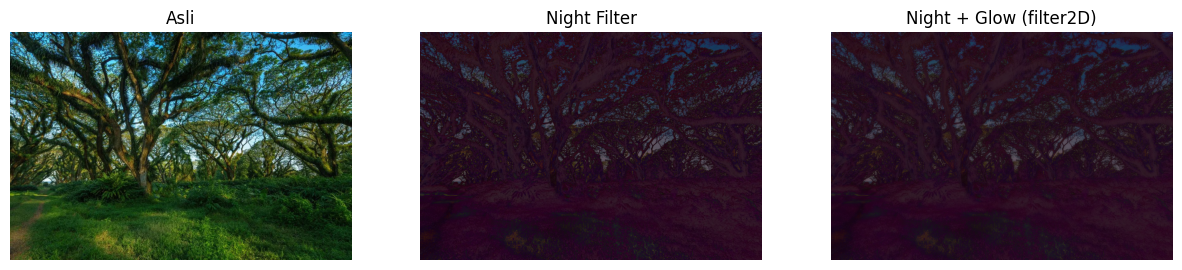

In [78]:
# Night Filter
img = cv.imread("/content/drive/MyDrive/PCVK25_3F_02/Images/djawatan.jpg")
img_gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Step 1: Gelapkan (contrast turun, brightness negatif)
night = cv.convertScaleAbs(img, alpha=0.6, beta=-40)

# Step 2: Tambah bias biru
blue_tint = np.full_like(night, (50, 0, 100)) # BGR
night = cv.addWeighted(night, 0.8, blue_tint, 0.2, 0)

# Step 3: Efek glow di area terang dengan filter2D (blur kernel)
kernel = np.ones((15,15), np.float32) / 225
glow = cv.filter2D(night, -1, kernel)

# Kombinasikan asli + glow
night_glow = cv.addWeighted(night, 0.7, glow, 0.3, 0)

show_side_by_side([img, night, night_glow],
                  ["Asli", "Night Filter", "Night + Glow (filter2D)"])

## Percobaan 7

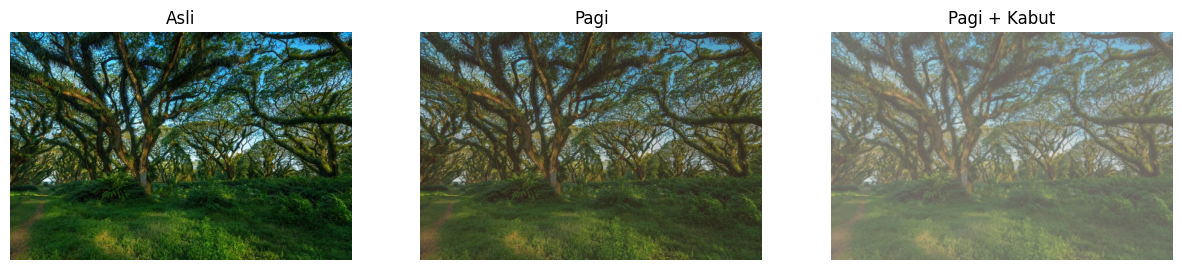

In [79]:
# Filter Suasana pagi dan Kabut
# ========================
# Step 1: Kurangi kontras & cerahkan
# ========================
alpha = 0.9 # contrast
beta = 20   # brightness
soft = cv.convertScaleAbs(img, alpha=alpha, beta=beta)

# ========================
# Step 2: Tambahkan warm tone (kemerahan / oranye)
# ========================
warm_tint = np.full_like(soft, (40, 70, 120)) # BGR
pagi = cv.addWeighted(soft, 0.8, warm_tint, 0.2, 0)

# ========================
# Step 3: Tambahkan haze (kabut tipis) dengan filter2D
# ========================
# Kernel blur Gaussian-like untuk menciptakan efek kabut
kernel = cv.getGaussianKernel(3, 3)
kernel = kernel @ kernel.T # jadikan 2D kernel
kabut = cv.filter2D(pagi, -1, kernel)

# tambah Layer putih untuk kabut lebih nyata
white_layer = np.full_like(pagi, 255)
kabut = cv.addWeighted(kabut, 0.7, white_layer, 0.3, 0)

show_side_by_side([img, pagi, kabut],
                  ["Asli", "Pagi", "Pagi + Kabut"])